In [1]:
import simpy
import numpy as np
import random
import matplotlib.pyplot as plt

STUDENT_NR_MAURITS = 14014777
STUDENT_NR_HARSHITA = 13807609

SEED = STUDENT_NR_MAURITS + STUDENT_NR_HARSHITA
random.seed(SEED)


In [88]:
plt.style.use('seaborn')

# M/M/m Queue Model(FIFO)
## In the customer function we have put a condition for steady state after analysing the behavior(shown in the below section)

In [89]:
# simpy works in minutes
# Here system is a shop
# Agent is - Customer
# Process - serving
# resource - cashier/shopkeeper
class System(object):
    def __init__(self,env,num_servers,lambda_a,mu,service_distribution,thresholdT):
        self.env = env
        self.server = simpy.Resource(env,capacity = num_servers)
        self.n = 0    # Total customers inside the shop
        self.lambd = lambda_a
        self.mu = mu
        self.serDist = service_distribution
        self.response_time = []
        self.wait_time = []
        self.queue_length = []
        self.customer = []
        self.thresholdTime = thresholdT # Time duration during which a customer is allowed to enter the system
        
    
def customer(env,system):
    arrival_time = env.now
   
    service_time = np.random.exponential(scale=1/system.mu)
    
    with system.server.request() as request_server:
        yield request_server
        
        # Steady State
        if(env.now > 250):
            waiting_time = env.now - arrival_time
            system.wait_time.append(waiting_time)
   
        
        #print('starting to serve the customer at %s' % (env.now))
        yield env.timeout(service_time)
        #print('Customer has purchades goods and is leaving the store at %s' % (env.now))
            
    response_time = env.now - arrival_time
    system.response_time.append(response_time)
    system.n =  system.n-1

    
def generate(env,system):
    # shop opens at time T1  closes at time T2 so T(Threshold Time) = T2-T1
    while(env.now <= system.thresholdTime):
        # First customer not arriving at time t = 0 but at inter_arrival time
        inter_arrival = np.random.exponential(scale=1/system.lambd)
        yield env.timeout(inter_arrival)
        env.process(customer(env,system))
        system.n += 1
        
        
def get_average(data):
    average = np.mean(data)
    return average


def observe(env,system):
    while(env.now < system.thresholdTime):
        system.queue_length.append(len(system.server.queue))  # number of customers in a queue at time t
        system.customer.append(system.n)
        #print(len(system.server.queue))
        yield env.timeout(1)
        
def calculate_lambda(rho,server,mu):
        lambd_a = rho*server*mu
        return lambd_a
            
    

# Steady state Analysis - 1 simulation run and different number of customers

In [269]:
T_threshold = np.arange(0,2400,10)  # Minutes

num_servers = [1]

mu = 15      # per minute
lambd = [25/4]

In [270]:
def customer_measure_steady_state(env,system):
    arrival_time = env.now
   
    service_time = np.random.exponential(scale=1/system.mu)
    
    with system.server.request() as request_server:
        yield request_server
        
        
        waiting_time = env.now - arrival_time
        system.wait_time.append(waiting_time)
   
        
        #print('starting to serve the customer at %s' % (env.now))
        yield env.timeout(service_time)
        #print('Customer has purchades goods and is leaving the store at %s' % (env.now))
            
    response_time = env.now - arrival_time
    system.response_time.append(response_time)
    system.n =  system.n-1
    
def generate_steady(env,system):
    # shop opens at time T1  closes at time T2 so T(Threshold Time) = T2-T1
    while(env.now <= system.thresholdTime):
        # First customer not arriving at time t = 0 but at inter_arrival time
        inter_arrival = np.random.exponential(scale=1/system.lambd)
        yield env.timeout(inter_arrival)
        env.process(customer_measure_steady_state(env,system))
        system.n += 1



service_distribution = "exponential"
avg_time = []


for i in range(len(num_servers)):
    avg_time_server = []
    print(lambd[i])
    for time in T_threshold:
        # Run the simulation
        env = simpy.Environment()
        system = System(env,num_servers[i],lambd[i],mu,service_distribution,time)
        env.process(generate_steady(env,system))
        env.process(observe(env,system))
        env.run()
        avg_time_server.append(get_average(system.wait_time))
    
    avg_time.append(avg_time_server)
    
    
   

6.25


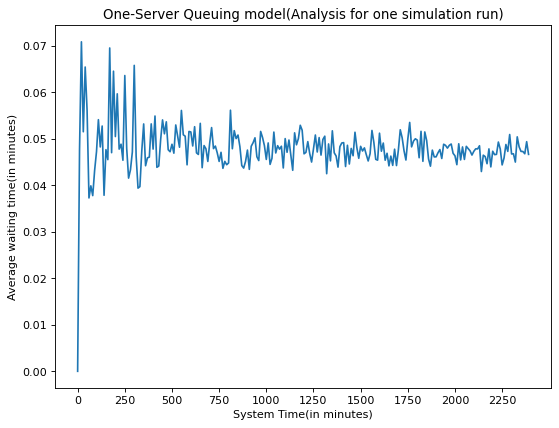

In [271]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.plot(T_threshold,avg_time_server)
plt.title("One-Server Queuing model(Analysis for one simulation run)")
#plt.yscale("log")
plt.xlabel("System Time(in minutes)")
plt.ylabel("Average waiting time(in minutes)")

plt.xticks(np.arange(0, 2500, 250))
plt.show()

# lambda = 25/4 = 6.25 customers per minute
# for 200 minutes - 1250 customers. 

System becomes stable after Time = 250 minutes

Therefore, for steady state behavior we don't consider the waiting time for customers till Time T = 250 minutes. This is an approximation of our analysis.

# Graph of convergence of waiting time with increase in simulation runs(M/M/1)
## Taking mean time of customers only after T = 250 minutes

In [272]:
num_sim = 1500
T_threshold = 1250 # In minutes  7500 customers
num_servers = [1]

rho = 0.4
mu = 15      # per minute
lambd = [25/4]

In [273]:
service_distribution = "exponential"


def simution_run(sim,num_servers,lambd,mu,service_distribution,time):
    avg_time = []
    y_data = []
    prev_estimated_mean = 0
    for i in range(sim):
        env = simpy.Environment()
        system = System(env,num_servers,lambd,mu,service_distribution,time)
        env.process(generate(env,system))
        env.process(observe(env,system))
        env.run()
        avg_time.append(get_average(system.wait_time))
        # mean value till this simulation run
        new_mean_till_now = prev_estimated_mean + (avg_time[-1] - prev_estimated_mean)/(i+1)
        #mean_till_now = np.mean(avg_time)
        y_data.append(new_mean_till_now)
        prev_estimated_mean = new_mean_till_now
    return(y_data)
    



for i in range(len(num_servers)):
    y_data_plot = []
    y_data_plot = simution_run(num_sim,num_servers[i],lambd[i],mu,service_distribution,T_threshold)
           

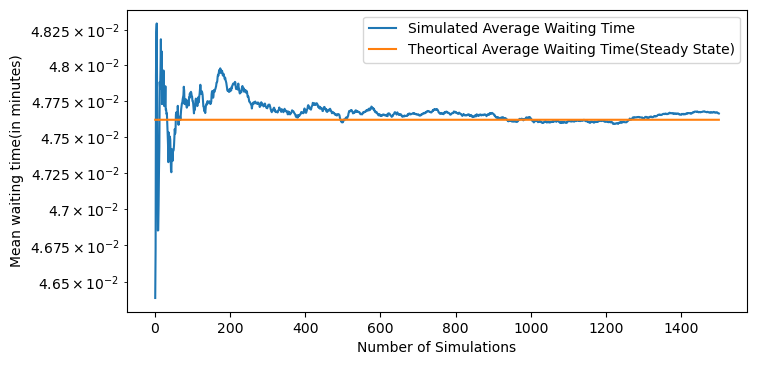

In [274]:
from matplotlib.pyplot import figure

figure(figsize=(8, 4), dpi=100)

rho = lambd[0]/mu
th_wait = rho/(mu*(1-rho))
theoritical_avg_wait = np.empty(num_sim)
theoritical_avg_wait.fill(th_wait)

x_data = np.arange(1,num_sim+1,1)
plt.plot(x_data,y_data_plot,label="Simulated Average Waiting Time")
plt.plot(x_data,theoritical_avg_wait,label="Theortical Average Waiting Time(Steady State)")
plt.legend()
plt.yscale("log")

plt.xlabel("Number of Simulations")
plt.ylabel("Mean waiting time(in minutes)")

plt.xticks(np.arange(0, 1500, 200))

plt.show()




# lambda = 25/4 = 6.25 customers per minute
# for 200 minutes - 1250 customers. 

## Based on the above analysis we choose T = 1250 minutes(approximately 7500 customers) and Simulation Runs = 500

In [224]:
T_threshold = 1250  # minutes
num_sim = 500

mu = 15
rho_arr = [0.4,0.55,0.7]
num_server = [1,2,4]


def calculate_lambda(rho,server,mu):
        lambd_a = rho*server*mu
        return lambd_a


In [225]:
data_plot = []


for rho in rho_arr:
    for server in num_server:
        print(rho)
        print(server)
        print("\n")
        lambda_a = calculate_lambda(rho,server,mu)
        rho_server_data = []
        avg_queue_length = []
        avg_wait_time = []
        avg_response_time = []
        avg_customers = []
        for sim in range(num_sim):
            # Run the simulation
            env = simpy.Environment()
            system = System(env,server,lambda_a,mu,service_distribution,T_threshold)
            env.process(generate(env,system))
            env.process(observe(env,system))
            env.run()
        
            avg_queue_length.append(get_average(system.queue_length))
            avg_wait_time.append(get_average(system.wait_time))
            avg_response_time.append(get_average(system.response_time))
            avg_customers.append(get_average(system.customer))
            
        
        rho_server_data.append(avg_wait_time)
        rho_server_data.append(avg_response_time)
        rho_server_data.append(avg_queue_length)
        rho_server_data.append(avg_customers)
        data_plot.append(rho_server_data)
                   
   # heading = ["Average Waiting Time","Average Response Time","Average Queue Length","Average Number of Customers in a System"]  
    
    
  

0.4
1


0.4
2


0.4
4


0.55
1


0.55
2


0.55
4


0.7
1


0.7
2


0.7
4




In [226]:
import json

with open("ServersFIFO.json", 'w') as f:
    json.dump(data_plot, f, indent=2) 

In [11]:
with open("ServersFIFO.json", 'r') as f:
    data_read = json.load(f)


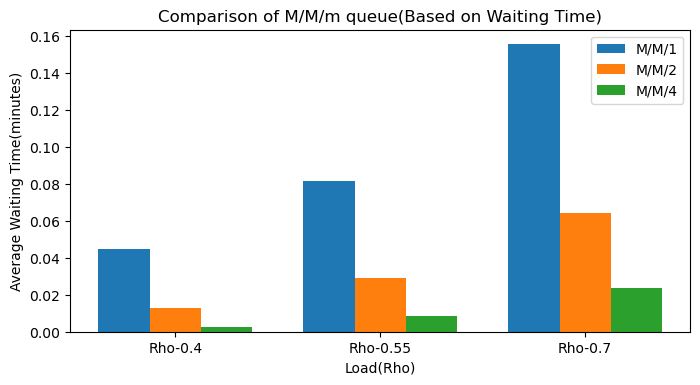

In [263]:
from matplotlib.pyplot import figure

figure(figsize=(8, 4), dpi=100)

rho_plot = [0.4,0.55,0.7]
num_server_plot = [1,2,4]

X = ['Rho-0.4','Rho-0.55','Rho-0.7']

X_axis = np.arange(len(X))

width = 0.25
  
plt.bar(X_axis , data[0:3], width, label = 'M/M/1')
plt.bar(X_axis + width, data[3:6], width, label = 'M/M/2')
plt.bar(X_axis + width*2, data[6:9], width, label = 'M/M/4')

plt.xlabel("Load(Rho)")
plt.ylabel('Average Waiting Time(minutes)')
plt.title("Comparison of M/M/m queue(Based on Waiting Time)")
  
plt.xticks(X_axis+width,['Rho-0.4','Rho-0.55','Rho-0.7'])

plt.legend()
plt.show()

In [3]:
import json 
import pandas as pd

with open("ServersFIFO.json", 'r') as f:
    data_read = json.load(f)
    
data_stats_04 = []
data_stats_55 = []
data_stats_07 = []

# For Rho - 0.4
data_range = [0,1,2]
    
for j in data_range:
    
    temp = data_read[j][:]
    # average time 
    data_temp = temp[0]
    data_stats_04.append(data_temp)
    
# For Rho - 0.55
data_range = [3,4,5]
    
for j in data_range:
    
    temp = data_read[j][:]
    # average time 
    data_temp = temp[0]
    data_stats_55.append(data_temp)
    
# For Rho - 0.7
data_range = [6,7,8]
    
for j in data_range:
    
    temp = data_read[j][:]
    # average time 
    data_temp = temp[0]
    data_stats_07.append(data_temp)

/Users/Cheema/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Cheema/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Cheema/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

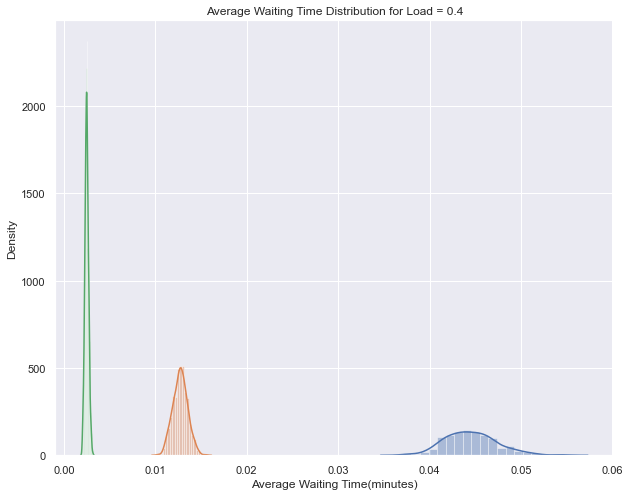

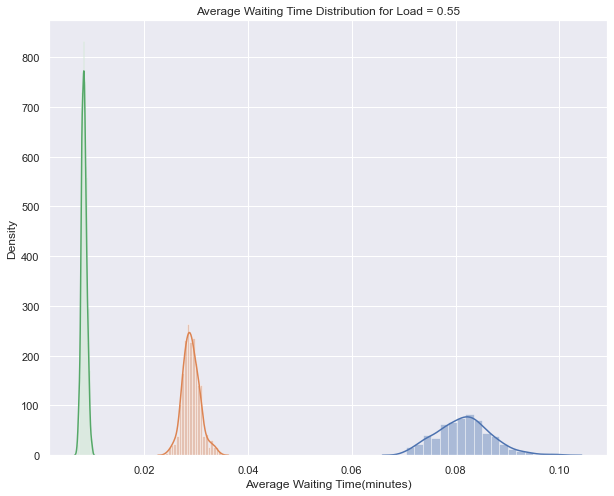

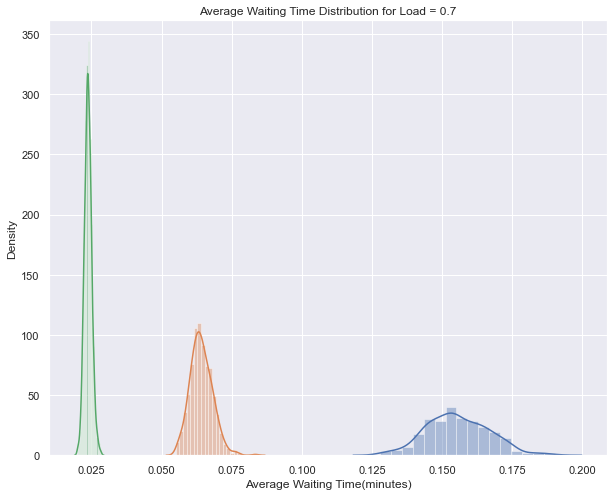

In [69]:

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={"figure.figsize": (10, 8)})

sns.set_theme()

fig1, ax1 = plt.subplots()
fig1, ax2 = plt.subplots()
fig1, ax3 = plt.subplots()

sns.distplot(data_stats_04[0], ax=ax1, kde=True,label="One Server(n=1)")
sns.distplot(data_stats_04[1], ax=ax1, kde=True,label= "Two Servers(n=2)")
sns.distplot(data_stats_04[2], ax=ax1, kde=True,label="Four Servers(n=4)")

sns.distplot(data_stats_55[0], ax=ax2, kde=True,label="One Server(n=1)")
sns.distplot(data_stats_55[1], ax=ax2, kde=True,label= "Two Servers(n=2)")
sns.distplot(data_stats_55[2], ax=ax2, kde=True,label="Four Servers(n=4)")

sns.distplot(data_stats_07[0], ax=ax3, kde=True,label="One Server(n=1)")
sns.distplot(data_stats_07[1], ax=ax3, kde=True,label= "Two Servers(n=2)")
sns.distplot(data_stats_07[2], ax=ax3, kde=True,label="Four Servers(n=4)")

ax1.set_xlabel("Average Waiting Time(minutes)")
ax2.set_xlabel("Average Waiting Time(minutes)")
ax3.set_xlabel("Average Waiting Time(minutes)")

ax1.set_title("Average Waiting Time Distribution for Load = 0.4")
ax2.set_title("Average Waiting Time Distribution for Load = 0.55")
ax3.set_title("Average Waiting Time Distribution for Load = 0.7")


plt.show()




## Average Wait Time, Response Time, Queue length, Customers in System for Rho = 0.4, 0.55 ,0.7and Servers = [1,2,4]

In [20]:
import pandas as pd
# Rho - 0.4, mu=15

# Lambda values
# Lambda = rho*num_server*mu
rho = 0.4
mu = 15
lambd = []
num_servers = [1,2,4]

for server in num_servers:
    lambd.append(rho*server*mu)
    


avg_queue = []
avg_wait_time = []
avg_customers = []
avg_response_time = []

data_range = [0,1,2]
    
for j in data_range:
    
    temp = data_read[j][:]
    avg_wait_time.append(np.mean(temp[0]))
    avg_response_time.append(np.mean(temp[1]))
    avg_queue.append(np.mean(temp[2]))
    avg_customers.append(np.mean(temp[3]))

df = pd.DataFrame([avg_wait_time, avg_response_time,avg_queue,avg_customers,lambd])
print(avg_wait_time)
print(avg_response_time)
print(avg_queue)
print(avg_customers)

df.columns =['N = 1', 'N = 2','N = 4']
df.index = ['Average Waiting Time(Min)', 'Average Response Time(Min)', 'Average Queue Length', 'Average Number of Customers','Lambda(Arrival rate per minute)']
  
# Change the row indexes

df.head()

[0.04453565400402572, 0.012733900785335263, 0.002503579634782806]
[0.11118399114336026, 0.0793719083395627, 0.06916868687290867]
[0.2670616, 0.1529176, 0.06042960000000001]
[0.667692, 0.9530232, 1.6606880000000002]


,N = 1,N = 2,N = 4
Average Waiting Time(Min),0.044536,0.012734,0.002504
Average Response Time(Min),0.111184,0.079372,0.069169
Average Queue Length,0.267062,0.152918,0.060430
Average Number of Customers,0.667692,0.953023,1.660688
Lambda(Arrival rate per minute),6.000000,12.000000,24.000000


In [26]:
# Rho - 0.55, mu=15

# Lambda values
# Lambda = rho*num_server*mu
rho = 0.55
mu = 15
lambd = []
num_servers = [1,2,4]

for server in num_servers:
    lambd.append(rho*server*mu)

avg_queue = []
avg_wait_time = []
avg_customers = []
avg_response_time = []

data_range = [3,4,5]
    
for j in data_range:
    
    temp = data_read[j][:]
    avg_wait_time.append(np.mean(temp[0]))
    avg_response_time.append(np.mean(temp[1]))
    avg_queue.append(np.mean(temp[2]))
    avg_customers.append(np.mean(temp[3]))
    
df_055 = pd.DataFrame([avg_wait_time, avg_response_time,avg_queue,avg_customers,lambd])
print(avg_wait_time)
print(avg_response_time)
print(avg_queue)
print(avg_customers)

df_055.columns =['N = 1', 'N = 2','N = 4']
df_055.index = ['Average Waiting Time(Min)', 'Average Response Time(Min)', 'Average Queue Length', 'Average Number of Customers','Lambda(Arrival rate per minute)']
  
# Change the row indexes

df_055.head()
      

[0.08160099651981605, 0.029096292995638824, 0.008465703155682654]
[0.14813733955352854, 0.09567976536175896, 0.075141044110209]
[0.6716056000000001, 0.4796312, 0.27922399999999997]
[1.2212392, 1.5794152, 2.478048]


,N = 1,N = 2,N = 4
Average Waiting Time(Min),0.081601,0.029096,0.008466
Average Response Time(Min),0.148137,0.095680,0.075141
Average Queue Length,0.671606,0.479631,0.279224
Average Number of Customers,1.221239,1.579415,2.478048
Lambda(Arrival rate per minute),8.250000,16.500000,33.000000


In [23]:
# Rho - 0.7, mu=15

# Lambda values
# Lambda = rho*num_server*mu
rho = 0.7
mu = 15
lambd = []
num_servers = [1,2,4]

for server in num_servers:
    lambd.append(rho*server*mu)

avg_queue = []
avg_wait_time = []
avg_customers = []
avg_response_time = []

data_range = [6,7,8]
    
for j in data_range:
    
    temp = data_read[j][:]
    avg_wait_time.append(np.mean(temp[0]))
    avg_response_time.append(np.mean(temp[1]))
    avg_queue.append(np.mean(temp[2]))
    avg_customers.append(np.mean(temp[3]))
    
df = pd.DataFrame([avg_wait_time, avg_response_time,avg_queue,avg_customers,lambd])
print(avg_wait_time)
print(avg_response_time)
print(avg_queue)
print(avg_customers)

df.columns =['N = 1', 'N = 2','N = 4']
df.index = ['Average Waiting Time(Min)', 'Average Response Time(Min)', 'Average Queue Length', 'Average Number of Customers','Lambda(Arrival rate per minute)']
  
# Change the row indexes

df.head()
      

[0.15558162469709397, 0.0641636152620564, 0.023789685281859582]
[0.22208712644744028, 0.13074509882160998, 0.09048446199558137]
[1.6323104, 1.3457048000000003, 1.0010416]
[2.3316712, 2.7446295999999997, 3.8001016]


,N = 1,N = 2,N = 4
Average Waiting Time(Min),0.155582,0.064164,0.023790
Average Response Time(Min),0.222087,0.130745,0.090484
Average Queue Length,1.632310,1.345705,1.001042
Average Number of Customers,2.331671,2.744630,3.800102
Lambda(Arrival rate per minute),10.500000,21.000000,42.000000


## We present two examples to compare the simulated and analytical values 

### 1. Theoritical Values for M/M/1 Verifies the simulated values

In [55]:
# We verify if our simulated values are close to analytical results. Here, we take rho = 0.55 and M/M/1 model to 
# see if our results match the expected theoritical values.

lambd = 8.25
rho = 0.55
mu = 15
wait = rho/(mu*(1-rho))
response = 1/(mu-lambd)
queue = rho**2/(1-rho)
cust = rho/(1-rho)

analytical_values = [wait,response,queue,cust]
simulated_series = df_055.iloc[:, 0]
simulated_values = series[:-1].to_numpy()

df = pd.DataFrame([analytical_values,simulated_values])

df.columns = ['Average Waiting Time', 'Average Response Time','Average Queue Length','Average Number of Customers']
df.index = ['Analytical Value(Theoretical)','Simulated Value']
df.head()


# Simulated and analytical values are similar(close)


,Average Waiting Time,Average Response Time,Average Queue Length,Average Number of Customers
Analytical Value(Theoretical),0.081481,0.148148,0.672222,1.222222
Simulated Value,0.081601,0.148137,0.671606,1.221239


### 2. Verifying Little's Law for M/M/2

In [59]:
# Now we also check for M/M/2 and see if the Little's law hold for the sub-system such that E[n_q] = lambda*E[w]
# E[w] = Expected waiting time and E[n_q] = Expected queue length

rho = 0.55
mu = 15
lambd = rho*2*mu

#wait = 2*(rho**3)/((1-rho**2)*(lambd))
#print(wait)

simulated_series = df_055.iloc[:, 1]
simulated_avg_waiting_time = simulated_series[0]
simulated_avg_queue_length = simulated_series[2]

print(simulated_avg_queue_length)
# Average Queue Length using Little's Law
print(simulated_avg_waiting_time*lambd)

# Simulated value is similar(close) the analytical values

0.4796312
0.4800888344280406


#### The above comparisons hold true for all the 3 models - M/M/1, M/M/2 and M/M/4. But we show only two examples to present how the comparison was done to verify our results.

## Confidence Interval(Average Waiting Time)

In [61]:

def get_confidence_interval(z_value,data, sample_size):
    """ calculates confidence interval for a given lamda and sample

    Args:
        lmda ([type]): fractile of confidence letter
        sample_std ([type]): sample standard deviation
        sample_size ([type]): int

    Returns:
        float: Confidence interval of the provided data. Lambda, sample_std, ample size
    """
    
    std = np.std(data,ddof=1)

    a = z_value * std / np.sqrt(sample_size)
    return a


In [62]:
# For 95% confidence Interval z_value = 1.96
z = 1.96
sample_size = 500 # Simulation runs


# Rho - 0.4

data_range = [0,1,2]
data_0_4 = []
    
for j in data_range:
    
    temp = data_read[j][:]
    # Avg wait time
    d = get_confidence_interval(z,temp[0],sample_size)
    mean = np.mean(temp[0])
    inter = (mean,d)
    data_0_4.append(inter)
    

# Rho - 0.55

data_range = [3,4,5]
data_5_5 = []
    
for j in data_range:
    
    temp = data_read[j][:]
    # Avg wait time
    d = get_confidence_interval(z,temp[0],sample_size)
    mean = np.mean(temp[0])
    inter = (mean,d)
    data_5_5.append(inter)

# Rho - 0.7
data_range = [6,7,8]
data_0_7 = []
    
for j in data_range:
    
    temp = data_read[j][:]
    # Avg wait time
    d = get_confidence_interval(z,temp[0],sample_size)
    mean = np.mean(temp[0])
    inter = (mean,d)
    data_0_7.append(inter)

In [69]:
# Data in minutes

df_min = pd.DataFrame([data_0_4,data_5_5,data_0_7])

df_min.columns = ['N=1', 'N=2','N=4']
df_min.index = ['Rho-0.4','Rho-0.5','Rho-0.7']

#print(data_0_4)
#print(data_5_5)
#print(data_0_7)

In [70]:
df_min.head()

,N=1,N=2,N=4
Rho-0.4,"(0.04453565400402572, 0.00024785741132644896)","(0.012733900785335263, 7.011750740079089e-05)","(0.002503579634782806, 1.7151633268584377e-05)"
Rho-0.5,"(0.08160099651981605, 0.00045465574810759247)","(0.029096292995638824, 0.0001484218863408711)","(0.008465703155682654, 4.4504381300114116e-05)"
Rho-0.7,"(0.15558162469709397, 0.0009682524841711334)","(0.0641636152620564, 0.00034829133536863524)","(0.023789685281859582, 0.00011227928355500909)"


In [72]:
# data in seconds so that we can see the confidence intervals in order of 1.
# For 95% confidence Interval z_value = 1.96
z = 1.96
sample_size = 500 # Simulation runs


# Rho - 0.4

data_range = [0,1,2]
data_0_4_seconds = []
    
for j in data_range:
    
    temp = data_read[j][:]
    # Avg wait time
    d = get_confidence_interval(z,temp[0],sample_size)*60
    mean = np.mean(temp[0])*60
    inter = (mean,d)
    data_0_4_seconds.append(inter)
    

# Rho - 0.55

data_range = [3,4,5]
data_5_5_seconds = []
    
for j in data_range:
    
    temp = data_read[j][:]
    # Avg wait time
    d = get_confidence_interval(z,temp[0],sample_size)*60
    mean = np.mean(temp[0])*60
    inter = (mean,d)
    data_5_5_seconds.append(inter)

# Rho - 0.7
data_range = [6,7,8]
data_0_7_seconds = []
    
for j in data_range:
    
    temp = data_read[j][:]
    # Avg wait time
    d = get_confidence_interval(z,temp[0],sample_size)*60
    mean = np.mean(temp[0])*60
    inter = (mean,d)
    data_0_7_seconds.append(inter)

In [73]:
# Data in seconds


df_seconds = pd.DataFrame([data_0_4_seconds,data_5_5_seconds,data_0_7_seconds])

df_seconds.columns = ['N=1', 'N=2','N=4']
df_seconds.index = ['Rho-0.4','Rho-0.5','Rho-0.7']
df_seconds.head()

#print(data_0_4)
#print(data_5_5)
#print(data_0_7)

,N=1,N=2,N=4
Rho-0.4,"(2.672139240241543, 0.014871444679586938)","(0.7640340471201158, 0.004207050444047454)","(0.15021477808696834, 0.0010290979961150627)"
Rho-0.5,"(4.8960597911889625, 0.02727934488645555)","(1.7457775797383295, 0.008905313180452266)","(0.5079421893409592, 0.002670262878006847)"
Rho-0.7,"(9.334897481825639, 0.058095149050268004)","(3.849816915723384, 0.020897480122118114)","(1.4273811169115749, 0.006736757013300545)"


# Statistical testing(To compare mean of two groups)

Welch's T-test

Welch's T-test assumption - 
Data is approximately normally distributed.


If you want to know whether one population mean is greater than or less than the other, perform a one-tailed t-test.

If the groups come from two different populations perform a two-sample t-test (independent test)

In [8]:
import json 
import pandas as pd

with open("ServersFIFO.json", 'r') as f:
    data_read = json.load(f)


In [81]:
#Ho:  µ(data1) = µ(data2)
# Higher values of the t-value, indicate that a large difference exists between the two sample sets
# Positive t-value implies  µ(data1) >  µ(data2)
def t_test(data1,data2,alpha):
    test = stats.ttest_ind(data1,data2,equal_var = False)
    if(test.pvalue<alpha):
        print("Reject Null Hypothesis, therefore unequal mean")
    else:
        print("Can't reject Null Hypothesis")
        
    if(test.statistic > 0):
        print("mean of first argument > mean of second argument")
        
    return test

In [87]:
import scipy
from scipy import stats
import numpy as np

#Ho:  µ(n=1) – µ(n=2) ≤ 0
#Ha:  µ(n=1) – µ(n=2) > 0
#Hypothesis(H0): A=B
#Hypothesis(H1): B>A

# two-sample one-tailed t-test

with open("ServersFIFO.json", 'r') as f:
    data_read = json.load(f)
    
    
data_stats_test = []
# for rho = 0.4

data_range = [0,1,2]
    
for j in data_range:
    
    temp = data_read[j][:]
    # only need average time for bar chart comparison
    data_temp = temp[0]
    data_stats_test.append(data_temp)

MM1_0_4 = data_stats_test[0]
MM2_0_4 = data_stats_test[1]
MM4_0_4 = data_stats_test[2]

alpha = 0.001
#significance level
    
# T-test for all the combinations
print("significance level = 0.001")
print("For Rho(load) Value of 0.4")
print("Mean comparison of M/M/1 vs M/M/2")
ttest_1_2_04 = t_test(MM1_0_4,MM2_0_4,alpha)
print("\n")
print("Mean comparison of M/M/1 vs M/M/4")
ttest_1_4_04 = t_test(MM1_0_4,MM4_0_4,alpha)
print("\n")
print("Mean comparison of M/M/2 vs M/M/4")
ttest_2_4_04 = t_test(MM2_0_4,MM4_0_4,alpha)






significance level = 0.001
For Rho(load) Value of 0.4
Mean comparison of M/M/1 vs M/M/2
Reject Null Hypothesis, therefore unequal mean
mean of first argument > mean of second argument


Mean comparison of M/M/1 vs M/M/4
Reject Null Hypothesis, therefore unequal mean
mean of first argument > mean of second argument


Mean comparison of M/M/2 vs M/M/4
Reject Null Hypothesis, therefore unequal mean
mean of first argument > mean of second argument


In [85]:
alpha = 0.001
#significance level

# for rho = 0.55
data_stats_test = []
data_range = [3,4,5]
    
for j in data_range:
    
    temp = data_read[j][:]
    # only need average time for bar chart comparison
    data_temp = temp[0]
    data_stats_test.append(data_temp)

MM1_0_5_5 = data_stats_test[0]
MM2_0_5_5 = data_stats_test[1]
MM4_0_5_5 = data_stats_test[2]

# T-test for all the combinations
print("For Rho(load) Value of 0.55")
print("significance level = 0.001")
print("\n")
print("Mean comparison of M/M/1 vs M/M/2")
ttest_1_2_55 = t_test(MM1_0_5_5,MM2_0_5_5,alpha)
print("\n")
print("Mean comparison of M/M/1 vs M/M/4")
ttest_1_4_55 = t_test(MM1_0_5_5,MM4_0_5_5,alpha)
print("\n")
print("Mean comparison of M/M/2 vs M/M/4")
ttest_2_4_55 = t_test(MM2_0_5_5,MM4_0_5_5,alpha)


# for rho = 0.7
data_stats_test = []

data_range = [6,7,8]
    
for j in data_range:
    
    temp = data_read[j][:]
    # only need average time for bar chart comparison
    data_temp = temp[0]
    data_stats_test.append(data_temp)

MM1_0_7 = data_stats_test[0]
MM2_0_7 = data_stats_test[1]
MM4_0_7 = data_stats_test[2]
    
alpha = 0.001
#significance level
    
# T-test for all the combinations
print("\n")
print("For Rho(load) Value of 0.7")
print("significance level = 0.001")
print("\n")
print("Mean comparison of M/M/1 vs M/M/2")
ttest_1_2_07 = t_test(MM1_0_7,MM2_0_7,alpha)
print("\n")
print("Mean comparison of M/M/1 vs M/M/4")
ttest_1_4_07 = t_test(MM1_0_7,MM4_0_7,alpha)
print("\n")
print("Mean comparison of M/M/2 vs M/M/4")
ttest_2_4_07 = t_test(MM2_0_7,MM4_0_7,alpha)


For Rho(load) Value of 0.55
significance level = 0.001


Mean comparison of M/M/1 vs M/M/2
Reject Null Hypothesis, therefore unequal mean
mean of first argument > mean of second argument


Mean comparison of M/M/1 vs M/M/4
Reject Null Hypothesis, therefore unequal mean
mean of first argument > mean of second argument


Mean comparison of M/M/2 vs M/M/4
Reject Null Hypothesis, therefore unequal mean
mean of first argument > mean of second argument


For Rho(load) Value of 0.7
significance level = 0.001


Mean comparison of M/M/1 vs M/M/2
Reject Null Hypothesis, therefore unequal mean
mean of first argument > mean of second argument


Mean comparison of M/M/1 vs M/M/4
Reject Null Hypothesis, therefore unequal mean
mean of first argument > mean of second argument


Mean comparison of M/M/2 vs M/M/4
Reject Null Hypothesis, therefore unequal mean
mean of first argument > mean of second argument


## With Increase in Rho value the sample Variance Increases for Average waiting(Simulation runs constant)
## We test this for M/M/1 model 


In [96]:
num_sim = 1500
T_threshold = 1250 # In minutes  7500 customers
num_servers = [1]

rho_arr = [0.1,0.3,0.45,0.55,0.6,0.7,0.8,0.9]
mean_waiting_time = []
waiting_std_dev = []
mu = 15      # per minute
num_sim = 50
server = 1
service_distribution = "exponential"

for rho in rho_arr:
    lambd = calculate_lambda(rho,server,mu)
    avg_waiting_time = []
    for sim in range(num_sim):
        # Run the simulation
        env = simpy.Environment()
        system = System(env,server,lambd,mu,service_distribution,T_threshold)
        env.process(generate(env,system))
        env.process(observe(env,system))
        env.run()
        avg_waiting_time.append(np.mean(system.wait_time))
            
    mean_waiting_time.append(np.mean(avg_waiting_time))
    waiting_std_dev.append(np.std(avg_waiting_time))
            
        

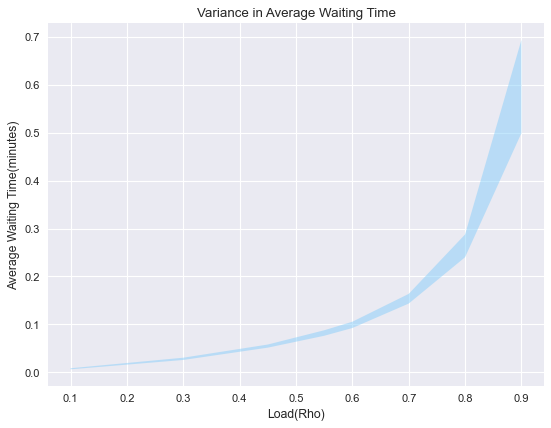

In [102]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
mean_waiting_time = np.array(mean_waiting_time)
waiting_std_dev = np.array(waiting_std_dev)

#plt.plot(rho_arr,mean_waiting_time)
plt.fill_between(rho_arr, mean_waiting_time+waiting_std_dev, mean_waiting_time-waiting_std_dev, facecolor='lightskyblue', alpha=0.5)
plt.xlabel('Load(Rho)')
plt.ylabel('Average Waiting Time(minutes)')
plt.title('Variance in Average Waiting Time')
plt.show()
